In [308]:
import matplotlib.pyplot as plt
import numpy as np
#v. 20220810.1
filedir = './data/'
outputdir = './output/'
filenames = ['CARAS65 .ELH']
fs = 500                        # частота дискретизации, Гц
first_stim_start_time = 1       # начало первого стимула, с
period = 5                      # период следования стимулов, с
background_start_time = 5       # начало фоновой засветки, с
background_duration = 90        # длительность фоновой засветки, с
sign = 1                        # полярность {1:'стимулы вверх', -1:'стимулы вниз'}
low_cutoff = 0.1                # частота среза highpass фильтра, Гц
stim_maximums_to_delete = []    # номера неудачных стимулов (перечислить через запятую)
stims_to_export = []            # номера стимулов для экспорта в файл (пример: [(0, 2), 25] - с 0 по 2, 25)
# начало первого импульса после фоновой засветки
after_background_start_time = first_stim_start_time + ((background_start_time + background_duration - first_stim_start_time) // period + 1) * period

In [309]:
# Чтение сигнала из файла(ов)
signal = []
for filename in filenames:
    with open(filedir + filename, 'r', encoding='utf-8') as file:
        file.readline()
        line = file.readline()
        while line and line[0] == '"':
            line = file.readline()
        signal.append(sign * float('0' if line == '.\n' else line))
        for line in file:
            signal.append(sign * float('0' if line == '.\n' else line))
signal = np.array(signal)

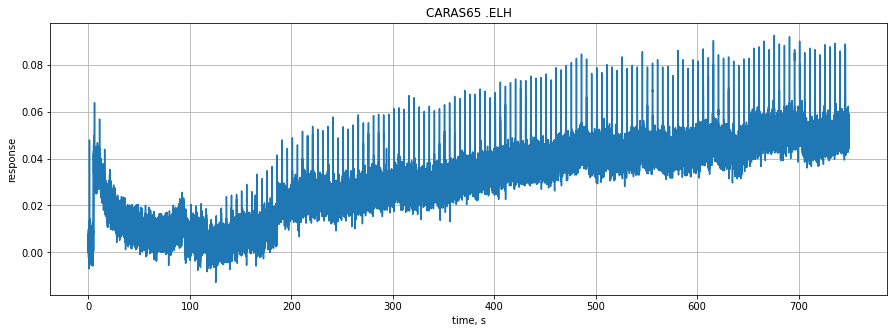

In [310]:
# Построение графика сигнала
n = signal.size
t = np.linspace(0, (n - 1) / fs, n)
fig, ax = plt.subplots()
ax.plot(t, signal)
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(','.join(filenames))
ax.grid()

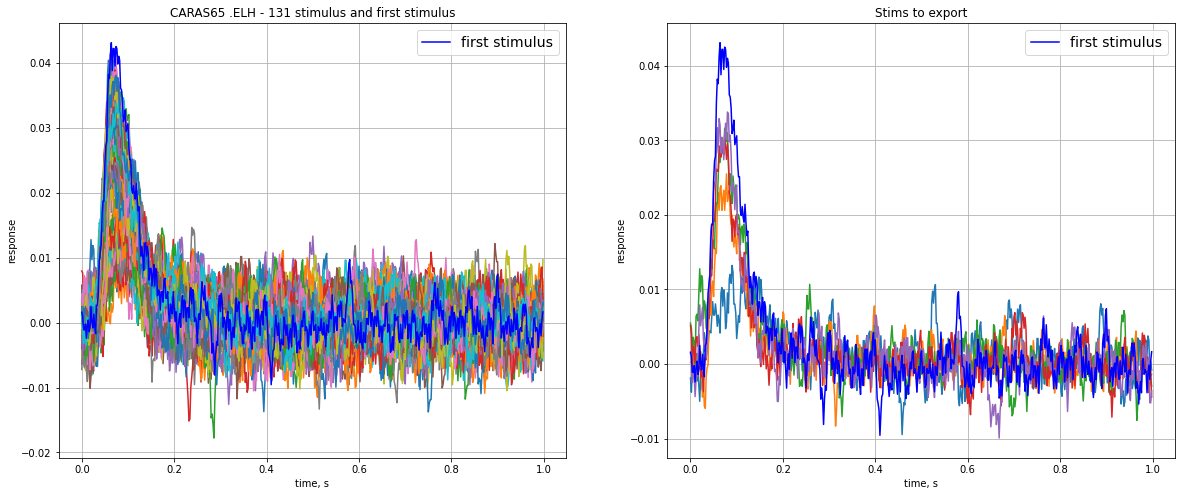

In [311]:
stims_cnt = ((n - 1) // fs - after_background_start_time) // period + 1
stims = []
prefix = fs // 5 # 0.2 секунды слева от стимула используются для расчета тренда
postfix = fs // 5 # последние 0.2 секунды стимула используются для расчета тренда
size = fs + prefix

# вычитание тренда из стимулов
for i in range(stims_cnt):
    begin = after_background_start_time * fs + period * i * fs - prefix
    end = begin + size
    stim = np.array(signal[begin:end])
    temp_t = np.linspace(0, (size - 1), size)
    x = np.concatenate([temp_t[:prefix], temp_t[size - postfix:]])
    y = np.concatenate([stim[:prefix], stim[size - postfix:]])
    s = np.polynomial.polynomial.Polynomial.fit(x, y, 1).convert().coef
    k, b = s[1], s[0]
    trend = k * temp_t + b
    stim = stim - trend
    stim = stim[prefix:]
    stims.append(stim)

# вычитание тренда из первого стимула
begin = first_stim_start_time * fs - prefix
end = begin + size
first_stim = np.array(signal[begin:end])
temp_t = np.linspace(0, (size - 1), size)
x = np.concatenate([temp_t[:prefix], temp_t[size - postfix:]])
y = np.concatenate([first_stim[:prefix], first_stim[size - postfix:]])
s = np.polynomial.polynomial.Polynomial.fit(x, y, 1).convert().coef
k, b = s[1], s[0]
trend = k * temp_t + b
first_stim = first_stim - trend
first_stim = first_stim[prefix:]
first_stim_max = first_stim.max()

size -= prefix
temp_t = np.linspace(0, 1 - 1 / fs, size)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(8)
for stim in stims:
    ax1.plot(temp_t, stim)
ax1.plot(temp_t, first_stim, 'b', label='first stimulus')
ax1.legend(prop={"size": 14})
ax1.set_xlabel('time, s')
ax1.set_ylabel('response')
ax1.set_title(f'{",".join(filenames)} - {stims_cnt} stimulus and first stimulus')
ax1.grid()

numbers = set()
if not stims_to_export:
    numbers = set(range(stims_cnt))
else:
    for number in stims_to_export:
        if type(number) is tuple:
            numbers |= set(range(number[0], number[1] + 1))
        else:
            numbers.add(number)
stims_to_export = list(sorted(numbers))
for number in stims_to_export:
    ax2.plot(temp_t, stims[number])
ax2.plot(temp_t, first_stim, 'b', label='first stimulus')
ax2.legend(prop={"size": 14})
ax2.set_xlabel('time, s')
ax2.set_ylabel('response')
ax2.set_title('Stims to export')
ax2.grid()

In [312]:
# Аппроксимация максимумов стимулов экспонентой
from scipy import stats, optimize

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

stim_maximums = np.array([stim.max() for stim in stims])

# Считается расстояние между началом первого импульса после фоновой засветки и ее концом
# График максимумов стимулов начинает строится в точке, равной рассчитанному расстоянию
begin = after_background_start_time - background_start_time - background_duration
end = begin + (stims_cnt - 1) * period
stim_maximums_x = np.linspace(begin, end, stims_cnt)

print('Номер\tВремя\tМаксимум')
for i, (x, stim_maximum) in enumerate(zip(stim_maximums_x, stim_maximums)):
    print(f'{i}\t{x}\t{stim_maximum:.4f}')

Номер	Время	Максимум
0	1.0	0.0132
1	6.0	0.0135
2	11.0	0.0122
3	16.0	0.0135
4	21.0	0.0133
5	26.0	0.0121
6	31.0	0.0135
7	36.0	0.0140
8	41.0	0.0192
9	46.0	0.0183
10	51.0	0.0181
11	56.0	0.0190
12	61.0	0.0210
13	66.0	0.0163
14	71.0	0.0252
15	76.0	0.0236
16	81.0	0.0241
17	86.0	0.0262
18	91.0	0.0223
19	96.0	0.0264
20	101.0	0.0255
21	106.0	0.0257
22	111.0	0.0244
23	116.0	0.0288
24	121.0	0.0260
25	126.0	0.0294
26	131.0	0.0283
27	136.0	0.0276
28	141.0	0.0289
29	146.0	0.0358
30	151.0	0.0264
31	156.0	0.0281
32	161.0	0.0304
33	166.0	0.0290
34	171.0	0.0329
35	176.0	0.0287
36	181.0	0.0292
37	186.0	0.0316
38	191.0	0.0308
39	196.0	0.0324
40	201.0	0.0316
41	206.0	0.0321
42	211.0	0.0316
43	216.0	0.0331
44	221.0	0.0401
45	226.0	0.0382
46	231.0	0.0346
47	236.0	0.0309
48	241.0	0.0346
49	246.0	0.0309
50	251.0	0.0328
51	256.0	0.0357
52	261.0	0.0332
53	266.0	0.0365
54	271.0	0.0333
55	276.0	0.0369
56	281.0	0.0341
57	286.0	0.0358
58	291.0	0.0360
59	296.0	0.0341
60	301.0	0.0308
61	306.0	0.0345
62	311.0	0.0354
63	

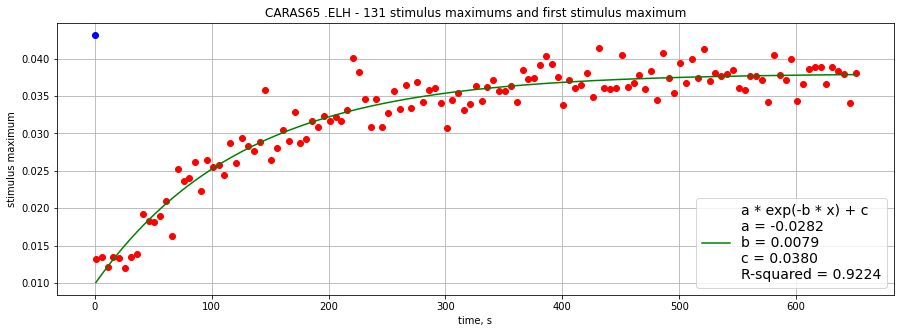

In [313]:
# Удаление неудачных максимумов стимулов
stim_maximums = np.delete(stim_maximums, stim_maximums_to_delete)
stim_maximums_x = np.delete(stim_maximums_x, stim_maximums_to_delete)

popt = (1, 1, 1)
try:
    popt, pcov = optimize.curve_fit(func, stim_maximums_x, stim_maximums, [-0.05, 0.01, 0.05])
except RuntimeError:
    print('Не удалось выполнить аппроксимацию. Подберите начальные коэффициенты.')
exp_a = popt[0]
exp_b = popt[1]
exp_c = popt[2]
fit = func(stim_maximums_x, *popt)
rvalue = stats.linregress(stim_maximums, fit).rvalue
r_squared = rvalue ** 2

fig, ax = plt.subplots()
ax.plot(stim_maximums_x, stim_maximums, 'ro')
ax.plot(0, first_stim_max, 'bo')
ax.plot(stim_maximums_x, fit, 'g', label=f'a * exp(-b * x) + c\n'
                           f'a = {exp_a:.4f}\n'
                           f'b = {exp_b:.4f}\n'
                           f'c = {exp_c:.4f}\n'
                           f'R-squared = {r_squared:.4f}')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('stimulus maximum')
ax.set_title(f'{",".join(filenames)} - {stim_maximums.size} stimulus maximums and first stimulus maximum')
ax.legend(prop={"size": 14})
ax.grid()

In [314]:
# Сохранение результатов в файлы
from pathlib import Path

Path(outputdir).mkdir(parents=True, exist_ok=True)
# Сохранение максимумов стимулов
with open(f'{outputdir}{",".join(filenames)}_out.txt', 'w', encoding='utf-8') as file:
    file.write(f'Файл(ы)\t{",".join(filenames)}\n')
    file.write(f'Длительность фона, c\t{background_duration}\n')
    file.write(f'Период следования стимулов, с\t{period}\n')
    file.write(f'Длительность записи, с\t{(n - 1) / fs}\n')
    file.write(f'Частота дискретизации, Гц\t{fs}\n')
    file.write(f'Параметр экспоненты a\t{exp_a:.4f}\n')
    file.write(f'Параметр экспоненты b\t{exp_b:.4f}\n')
    file.write(f'Параметр экспоненты c\t{exp_c:.4f}\n')
    file.write(f'Постоянная времени 1/b\t{1 / exp_b:.4f}\n')
    file.write(f'R-squared\t{r_squared:.4f}\n')
    file.write('\n')
    file.write('time, с\tU, у.е\tфункция аппроксимации (a * exp(-b * x) + c)\n')
    file.write(f'{0}\t{first_stim_max}\n')
    for i in range(stim_maximums.size):
        file.write(f'{stim_maximums_x[i]}\t{stim_maximums[i]}\t{fit[i]}\n')

# Сохранение стимулов
with open(f'{outputdir}{",".join(filenames)}_resp.txt', 'w', encoding='utf-8') as file:
    file.write(f'Файл(ы)\t{",".join(filenames)}\n')
    file.write(f'Длительность фона, c\t{background_duration}\n')
    file.write(f'Период следования стимулов, с\t{period}\n')
    file.write(f'Длительность записи, с\t{(n - 1) / fs}\n')
    file.write(f'Частота дискретизации, Гц\t{fs}\n')
    file.write('\n')
    file.write('time, с\tОпорный\t')
    for number in stims_to_export:
        file.write(f'{number}\t')
    file.write('\n')
    size = first_stim.size
    temp_t = np.linspace(0, 1 - 1 / fs, size)
    for i in range(size):
        file.write(f'{temp_t[i]:.4f}\t{first_stim[i]}\t')
        for number in stims_to_export:
            file.write(f'{stims[number][i]}\t')
        file.write('\n')

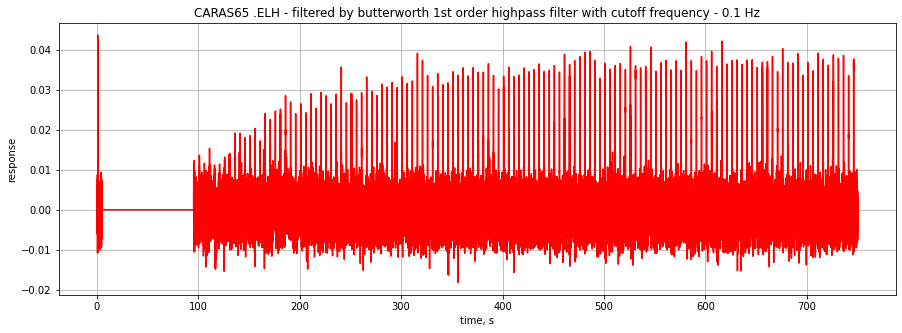

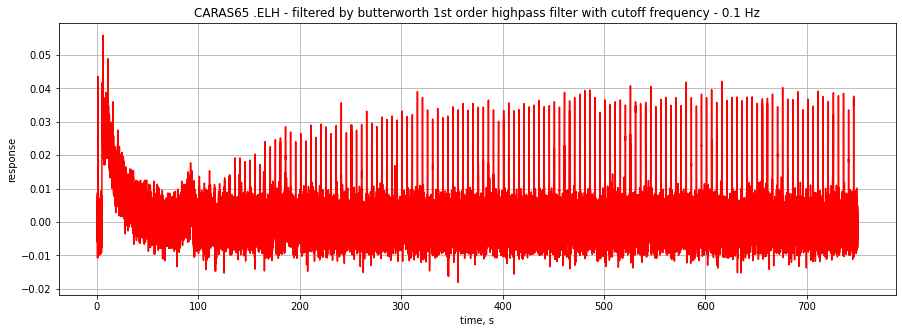

In [315]:
# Следующий блок кода используется только в целях красивого построения графика сигнала, отфильтрованного highpass фильтром Баттерворта.
# В расчетах максимумов стимулов и экспоненты отфильтрованный сигнал не участвует,
# так как фильтр немного обрезает максимум стимулов и добавляет отрицательный зубец на нисходящем фронте стимула

# Смещение сигнала до начала фона к 0
signal[:background_start_time * fs] -= signal[:first_stim_start_time * fs].mean()
begin = background_start_time * fs
end = after_background_start_time * fs - (after_background_start_time - background_start_time - background_duration) * fs // 2
# Копия фона - необходима, чтобы его потом нарисовать вместе с отфильтрованным сигналом
background = np.array(signal[begin:end])
# Смещение сигнала после окончания фона к 0
signal[end:] -= signal[end:after_background_start_time * fs].mean()
# Удаление фона, для того чтобы избежать переходного процесса фильтра после него и измерить высоту первого после него стимула
signal[begin:end] = 0

from scipy.signal import butter, lfilter
nyq = 0.5 * fs
b, a = butter(1, low_cutoff / nyq, btype='highpass', analog=False)
filtered = lfilter(b, a, signal)
fig, ax = plt.subplots()
ax.plot(t, filtered, 'r')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(f'{",".join(filenames)} - filtered by butterworth 1st order highpass filter with cutoff frequency - {low_cutoff} Hz')
ax.grid()

# Возврат ступеньки, смещенной к нулю, в отфильтрованный сигнал, просто чтобы ее нарисовать
begin = background_start_time * fs
end = after_background_start_time * fs - (after_background_start_time - background_start_time - background_duration) * fs // 2
filtered[begin:end] = background - background[0]
fig, ax = plt.subplots()
ax.plot(t, filtered, 'r')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(f'{",".join(filenames)} - filtered by butterworth 1st order highpass filter with cutoff frequency - {low_cutoff} Hz')
ax.grid()